In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
churn = pd.read_csv('./data/churn.csv')
churn.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,42,2,0.00,1,1,1,101348.88,1
1,608,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,39,1,0.00,2,0,0,93826.63,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0


In [3]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Gender           10000 non-null  int64  
 2   Age              10000 non-null  int64  
 3   Tenure           10000 non-null  int64  
 4   Balance          10000 non-null  float64
 5   NumOfProducts    10000 non-null  int64  
 6   HasCrCard        10000 non-null  int64  
 7   IsActiveMember   10000 non-null  int64  
 8   EstimatedSalary  10000 non-null  float64
 9   Exited           10000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 781.4 KB


In [4]:
churn.Exited.value_counts() #목표변수에 대한 분포 확인

0    7963
1    2037
Name: Exited, dtype: int64

In [5]:
np.random.seed(2022)
target = churn.Exited
churn = churn.drop(columns='Exited')

### Voting

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

x_train, x_test, y_train, y_test = train_test_split(churn, target, test_size=0.3, stratify=target)
# train, test set 을 나눌 때 target의 비율을 맞추는 옵션, stratify(층하추출)

lr = LogisticRegression()
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

lr.fit(x_train, y_train)
knn.fit(x_train, y_train)
dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [7]:
lr.coef_ # 로지스틱의 계수추출
pd.Series(lr.coef_[0], index=x_train.columns).sort_values() # 계수 추출 후 시리즈로 만듦
# 데이터의 스케일을 맞추지 않았기 때문에, 그대로 받아들이기보단 방향성 정도만 파악하는 것이 좋음

CreditScore       -0.004947
IsActiveMember    -0.001484
Tenure            -0.001136
Gender            -0.001008
NumOfProducts     -0.000539
HasCrCard         -0.000167
EstimatedSalary   -0.000001
Balance            0.000003
Age                0.043028
dtype: float64

In [8]:
# 변수중요도 파악
pd.Series(dt.feature_importances_, index=x_train.columns).sort_values()

HasCrCard          0.015338
Gender             0.018054
IsActiveMember     0.058785
Tenure             0.080518
NumOfProducts      0.110115
Balance            0.141309
CreditScore        0.159064
EstimatedSalary    0.181505
Age                0.235311
dtype: float64

In [9]:
# Hard Voting 
# Scartch Code
((lr.predict(x_test) + dt.predict(x_test) + knn.predict(x_test)) >= 2).astype('int') #2 이상이면 1, 아니면 0

array([0, 0, 0, ..., 0, 0, 0])

In [10]:
# Soft Voting 
# Scratch Code
(lr.predict_proba(x_test)[:,1] + dt.predict_proba(x_test)[:,1] + knn.predict_proba(x_test)[:,1])/3 #1 일 때의 확률값

array([0.32144481, 0.04380319, 0.03387368, ..., 0.61350975, 0.01859872,
       0.02837519])

In [11]:
from sklearn.ensemble import VotingClassifier
models = [('LR',lr),
         ('DT',dt),
         ('KNN',knn)] #모델을 튜플형태로 리스트로 저장
hard_vot = VotingClassifier(estimators=models, voting='hard')
soft_vot = VotingClassifier(estimators=models, voting='soft')

hard_vot.fit(x_train, y_train)
soft_vot.fit(x_train, y_train)

VotingClassifier(estimators=[('LR', LogisticRegression()),
                             ('DT', DecisionTreeClassifier()),
                             ('KNN', KNeighborsClassifier())],
                 voting='soft')

In [12]:
# ROC_AUC score를 통한 성능 측정 
# accuracy score 로는 balance가 맞지 않기 때문에 측정하기 쉽지 않음
from sklearn.metrics import roc_auc_score

my_models = [lr, dt, knn, hard_vot, soft_vot]
for m in my_models:
    try:
        pred = m.predict_proba(x_test)[:,1]
    except:
        pred = m.predict(x_test)
    name= m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name,score))
# .4f = 소수점 4자리까지 출력
# hard voting은 class를 결정하는 것이기 때문에 확률값이 나오지 않으므로 proba 불가능
# try-except 를 통해서 오류가 발생할 경우, predict 진행하도록 코딩

LogisticRegression ROC-AUC SCORE: 0.6728
DecisionTreeClassifier ROC-AUC SCORE: 0.6580
KNeighborsClassifier ROC-AUC SCORE: 0.5323
VotingClassifier ROC-AUC SCORE: 0.5379
VotingClassifier ROC-AUC SCORE: 0.7011


### Random Forest

In [13]:
# 트리기반 앙상블 모델 'Random Forest'
# 랜덤포레스트는 bagging의 한 기법, 데이터의 일부 변수를 선택해 모델을 여러개 만들어나가는 기법
# bagging 이란 데이터set의 일부를 샘플링해서 여러 개 set을 만들어나가는 기법
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=10)

In [14]:
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [15]:
models = [('LR',lr),
         ('DT',dt),
         ('RF',rf)] #모델을 튜플형태로 리스트로 저장
         
soft_vot_sum = VotingClassifier(estimators=models, voting='soft')
soft_vot_sum.fit(x_train, y_train)

my_models = [lr, dt, soft_vot, rf, soft_vot_sum]
for m in my_models:
    pred = m.predict_proba(x_test)[:,1]
    name= m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name,score))
# knn 성능이 너무 안좋으므로 빼면, 성능이 더 오름

LogisticRegression ROC-AUC SCORE: 0.6728
DecisionTreeClassifier ROC-AUC SCORE: 0.6580
VotingClassifier ROC-AUC SCORE: 0.7011
RandomForestClassifier ROC-AUC SCORE: 0.8532
VotingClassifier ROC-AUC SCORE: 0.8086


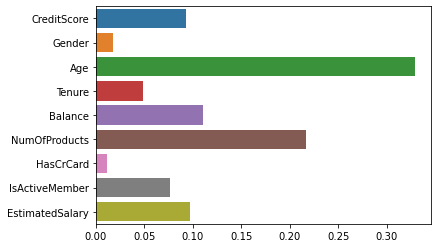

In [16]:
#RandomForest가 설명력은 낮지만, Feature importance는 뽑을 수 있음
sns.barplot(x=rf.feature_importances_, y=x_train.columns)

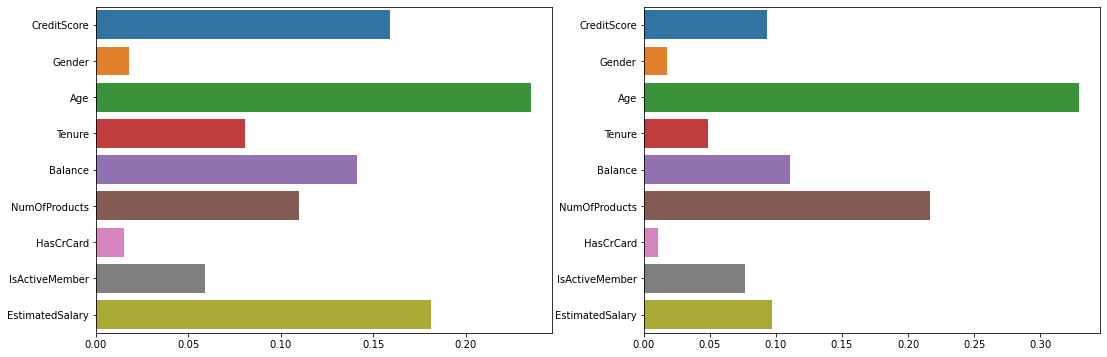

In [17]:
# Decision Tree, RandomForest 의 Feature Importance
fig, ax = plt.subplots(ncols=2, figsize=(18,6));
sns.barplot(x=dt.feature_importances_, y=x_train.columns, ax=ax[0]);
sns.barplot(x=rf.feature_importances_, y=x_train.columns, ax=ax[1]);

### 아다부스팅(AdaBoosting)
- 데이터에서 하나의 모델을 만든 뒤, 못 맞춘 부분에 가중치를 둬서, 맞춘 부분과 함께 두 번째 모델을 만들고, 과정의 반복
- 부스팅을 할 베이스 모델을 지정해줘야함 (base_estimator), prodict_proba를 제공하는 모델만 가능하며 Tree계열이 높은 성능을 보임
- 랜덤포레스트를 사용할 경우 Overfitting 발생, 간단한 모델을 제공하는 것이 좋음
- 모형의 갯수를 많이 쓰면 복잡한 모형이 만들어져서 Over-fitting이 발생할 확률이 높아서 조절해줘야함, 보통 50개 정도
- 학습률(learning_rate)이 크면 클수록 전혀 다른 모델을 만들려고 함 -> 못 맞춘 부분에만 집중해서 전혀 다른 모델을 만들려고 함, 학습률이 높을수록 복잡한 모델이 만들어짐
- 학습률과 n_estimator의 갯수는 trade-off하게 설정해야함

### 그래디언트부스팅(GBM)
- 모델을 점점 더 복잡하게 만들면서, 과적합을 만들어서, 점점 fitting 되게 기울기(오차를 계산하는 식)를 낮춰가는 방식
- 경사하강법에서 사용할 loss function을 지정해줘야함
- 분류문제에선 friedman_mes, 추정문제에선 mae나 mse 사용

In [18]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(base_estimator = dt, learning_rate=0.3) #fitting한 모델을 주며, dt가 보통 좋다고 알려져 있음
ada.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), learning_rate=0.3)

In [19]:
models = [('LR',lr),
         ('DT',dt),
         ('RF',rf),
         ('ADA',ada)] #모델을 튜플형태로 리스트로 저장
soft_vot_sum = VotingClassifier(estimators=models, voting='soft')
soft_vot_sum.fit(x_train, y_train)
my_models = [lr, dt, soft_vot, rf, soft_vot_sum,ada]
for m in my_models:
    pred = m.predict_proba(x_test)[:,1]
    name= m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name,score))

LogisticRegression ROC-AUC SCORE: 0.6728
DecisionTreeClassifier ROC-AUC SCORE: 0.6580
VotingClassifier ROC-AUC SCORE: 0.7011
RandomForestClassifier ROC-AUC SCORE: 0.8532
VotingClassifier ROC-AUC SCORE: 0.8043
AdaBoostClassifier ROC-AUC SCORE: 0.6491


In [20]:
from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()
gbm.fit(x_train,y_train)

models = [('RF',rf),
         ('GBM',gbm)] #모델을 튜플형태로 리스트로 저장
soft_vot_sum = VotingClassifier(estimators=models, voting='soft')
soft_vot_sum.fit(x_train, y_train)
my_models = [lr, dt, soft_vot, rf, soft_vot_sum,ada,gbm]
for m in my_models:
    pred = m.predict_proba(x_test)[:,1]
    name= m.__class__.__name__
    score = roc_auc_score(y_test, pred)
    print('{0} ROC-AUC SCORE: {1:.4f}'.format(name,score))

LogisticRegression ROC-AUC SCORE: 0.6728
DecisionTreeClassifier ROC-AUC SCORE: 0.6580
VotingClassifier ROC-AUC SCORE: 0.7011
RandomForestClassifier ROC-AUC SCORE: 0.8532
VotingClassifier ROC-AUC SCORE: 0.8605
AdaBoostClassifier ROC-AUC SCORE: 0.6491
GradientBoostingClassifier ROC-AUC SCORE: 0.8605
